# Using Scikit-Surprise

Surprise!

It's a well-developed CF wrapper that handles what we've just discovered, and more.

Essentially it has created everything we needed.

## Approach

If you recall, we don't use the full dataset as it's extremely large.
Thus, by taking a small representative sample, we can run **quick** tests that estimates the population behaviour.

Then, we narrow down the best parameters after we select the best few algorithms.

## Data Preparation

As usual, we take a representative sample from the set.

We also alter it to make it suitable for `surprise`.

In [18]:
import warnings
from pathlib import Path

import pandas as pd
from sklearn.preprocessing import QuantileTransformer

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top10k").joined_filtered_df,
    unpopular_maps_thres=None,
    unpopular_plays_thres=None,
    sr_min_thres=0,
    acc_filter=(0.8, 1),
    score_filter=None
).filter(calc_acc=True)
df: pd.DataFrame
df = df.rename({'accuracy': 'acc',
                'map_id': 'mid'}, axis=1)
qt = QuantileTransformer()
df[['acc_qt']] = qt.fit_transform(df['acc'].to_numpy().reshape(-1, 1))
df['uid'] = df['user_id'].astype(str) + "/" + df['year'].astype(str)
df = df[['uid', 'mid', 'acc_qt']]
df = df.reset_index(drop=True)
df = df.groupby(['uid', 'mid']).agg('mean').reset_index()

by_score_year 6021393 -> 3913111
by_sr 3913111 -> 3913111
by_acc_filter 3913111 -> 3912841
by_remove_mod 3912841 -> 3137489
Users Left: 9890 | Beatmaps Left: 6622


In [19]:
df['uid'] = df['uid'].astype(str)
df['mid'] = df['mid'].astype(str)
df.to_csv("top10k_april_22.csv", index=False)

`surprise` expects the input to be in: `[uid, iid, rating]`.
- `uid == player_id`
- `iid == map_id`
- `rating == accuracy/score`

In [2]:
from surprise import Reader, Dataset as DatasetSP

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0, 1))
# The columns must correspond to user id, item id and ratings (in that order).
data = DatasetSP.load_from_df(df, reader)

In [3]:

from surprise.prediction_algorithms import KNNBaseline

from surprise.model_selection import train_test_split

train, test = train_test_split(data)
model = KNNBaseline(
    k=13,
    sim_options={
        'name': 'msd',
        'min_support': 16,
        'user_based': False
    },
    bsl_options={
        "method": "sgd",
        "reg": 0.005,
        "learning_rate": 0.005,
        "n_epochs": 35
    }
)
model.fit(train)
eval = model.test(test)

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


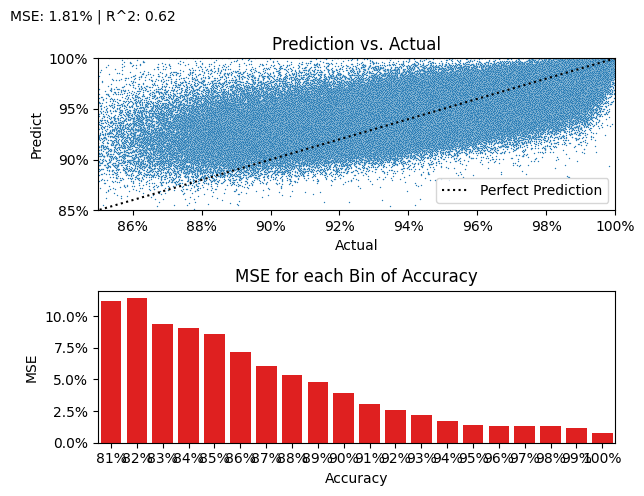

In [5]:
from opal.score.similarity.similarity_eval import plot_eval

df_eval = pd.DataFrame(
    [(e.r_ui, e.est) for e in eval],
    columns=['actual', 'pred']
)
plot_eval(df_eval)

In [6]:
train, test = train_test_split(data, test_size=0.00001, random_state=0)
model.fit(train)

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [5]:
df.to_pickle("beforepred.pkl")

In [7]:
import numpy as np

np.savez_compressed(
    "model_params.npz",
    sim=model.sim.base,
    bi=model.bi,
    bu=model.bu,
    bx=model.bx,
    by=model.by,
    xr=model.xr,
    yr=model.yr,
    n_x=model.n_x,
    n_y=model.n_y,
    trainset=model.trainset
)